# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [5]:
# import libraries here; add more as necessary
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import boto3
from sagemaker import get_execution_role
# magic word for producing visualizations in notebook
%matplotlib inline

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [346]:
bucket='capstone_project'

population_data_key = 'Udacity_AZDIAS_052018.csv'
customer_data_key = 'Udacity_CUSTOMERS_052018.csv'

data_location = 's3://sagemaker-us-east-1-399684875495/capstone_project/' # 's3://{}/{}'.format(bucket, data_key)

In [347]:
%%time
customer_df = pd.read_csv(data_location + customer_data_key, sep=';')

<string>:2: DtypeWarning: Columns (18,19) have mixed types.Specify dtype option on import or set low_memory=False.


CPU times: user 5.93 s, sys: 634 ms, total: 6.57 s
Wall time: 12.1 s


In [4]:
# population_df = pd.read_csv(data_location + population_data_key, sep=';')

/home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (18,19) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Of the 396 features, only 96 features does not have missing value for any customers. Therefore, it is unfair just to discard a feature if it has missing value for certain persons. Instead, we need to look at the distribution of proportion of missing data for each feature.

In [348]:
num_customers = customer_df.index.size
num_features = customer_df.columns.size

In [349]:
num_customers

191652

In [350]:
num_features

369

# Data Cleaning and Data Processing

## 1. Data Cleaning

### a. Convert unknown and missing values to nan

There are three type of values that should be considered nan:
- nan in cell
- categorical data with unknown value (-1,0, or 9)
- numerical data with out-of-range value, e.g. 0 for birth year

First I will convert all these to nan.

In [351]:
all_columns = customer_df.columns.to_list()

In [352]:
numerical_columns = ['GEBURTSJAHR',"KBA13_ANZAHL_PKW","MIN_GEBAEUDEJAHR","ANZ_HAUSHALTE_AKTIV","ANZ_HH_TITEL","ANZ_PERSONEN","ANZ_TITEL"]

In [353]:
# column names where 0 means unknown
unknown_0_columns = ['ALTERSKATEGORIE_GROB','KKK','ANREDE_KZ','GEBAEUDETYP','GEOSCORE_KLS7','HAUSHALTSSTRUKTUR','HH_EINKOMMEN_SCORE',
                     'KBA05_BAUMAX','KBA05_GBZ','KKK','NATIONALITAET_KZ','PRAEGENDE_JUGENDJAHRE','REGIOTYP','TITEL_KZ','WOHNDAUER_2008','WACHSTUMSGEBIET_NB','W_KEIT_KIND_HH']
unknown_0_columns = unknown_0_columns + numerical_columns

unknown_0_columns = set(unknown_0_columns).intersection(all_columns)

# columns where 9 does not mean unknown
value_9_columns = ['ALTER_HH','CAMEO_DEUG_2015','D19_BANKEN_DATUM','D19_BANKEN_OFFLINE_DATUM','D19_BANKEN_ONLINE_DATUM','D19_BANKEN_ONLINE_QUOTE_12',
                  'D19_GESAMT_DATUM','D19_GESAMT_OFFLINE_DATUM','D19_GESAMT_ONLINE_DATUM','D19_GESAMT_ONLINE_QUOTE_12','D19_TELKO_DATUM','D19_TELKO_OFFLINE_DATUM',
                   'D19_TELKO_ONLINE_DATUM','D19_VERSAND_DATUM','D19_VERSAND_OFFLINE_DATUM','D19_VERSAND_ONLINE_DATUM','D19_VERSAND_ONLINE_QUOTE_12','GFK_URLAUBERTYP',
                  'HAUSHALTSSTRUKTUR']
# columns where 9 means unknown
unknown_9_columns = list(set(all_columns) - set(value_9_columns).intersection(all_columns))

# -1 in all columns means unknown 

In [10]:
clean_customer_data = customer_df.copy()

In [11]:
print(unknown_0_columns)

{'REGIOTYP', 'GEBAEUDETYP', 'ALTERSKATEGORIE_GROB', 'HH_EINKOMMEN_SCORE', 'KBA05_GBZ', 'NATIONALITAET_KZ', 'ANREDE_KZ', 'ANZ_PERSONEN', 'ANZ_HAUSHALTE_AKTIV', 'ANZ_TITEL', 'WOHNDAUER_2008', 'W_KEIT_KIND_HH', 'MIN_GEBAEUDEJAHR', 'ANZ_HH_TITEL', 'PRAEGENDE_JUGENDJAHRE', 'TITEL_KZ', 'KBA13_ANZAHL_PKW', 'KBA05_BAUMAX', 'GEBURTSJAHR', 'KKK'}


In [12]:
clean_customer_data.loc[:,unknown_0_columns] = clean_customer_data.loc[:,unknown_0_columns].replace(0, np.nan)

clean_customer_data.loc[:,unknown_9_columns] = clean_customer_data.loc[:,unknown_9_columns].replace(9, np.nan)
clean_customer_data = clean_customer_data.replace(-1, np.nan)

In [13]:
clean_customer_data.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,9626.0,2.0,1.0,10.0,NaN,NaN,NaN,NaN,10.0,1.0,...,2.0,6.0,NaN,7.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,4.0
1,9628.0,NaN,NaN,11.0,NaN,NaN,NaN,NaN,NaN,NaN,...,3.0,NaN,NaN,NaN,3,FOOD,SINGLE_BUYER,0,1,4.0
2,143872.0,NaN,1.0,6.0,NaN,NaN,NaN,NaN,0.0,1.0,...,11.0,6.0,NaN,2.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,2,4.0
3,143873.0,1.0,1.0,8.0,NaN,NaN,NaN,NaN,8.0,NaN,...,2.0,NaN,NaN,7.0,1,COSMETIC,MULTI_BUYER,0,1,4.0
4,143874.0,NaN,1.0,20.0,NaN,NaN,NaN,NaN,14.0,7.0,...,4.0,2.0,NaN,3.0,1,FOOD,MULTI_BUYER,0,1,3.0


Make sure data is cleaned

In [16]:
clean_customer_data['GEBURTSJAHR']

0            NaN
1            NaN
2            NaN
3            NaN
4         1960.0
           ...  
191647       NaN
191648       NaN
191649    1944.0
191650       NaN
191651    1937.0
Name: GEBURTSJAHR, Length: 191652, dtype: float64

In [14]:
-1 in clean_customer_data

False

In [15]:
0 in clean_customer_data

False

Before going further, let's take a look at how many features are missing column-wise and row-wise.

In [16]:
clean_customer_data.isnull().sum(axis=1).sort_values().values

array([  2,   3,   3, ..., 266, 268, 268])

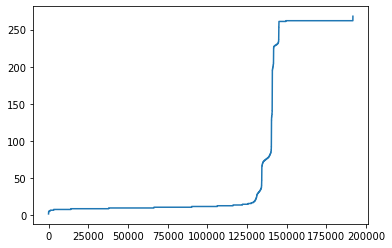

In [17]:
plt.plot(clean_customer_data.isnull().sum(axis=1).sort_values().values)

<AxesSubplot:>

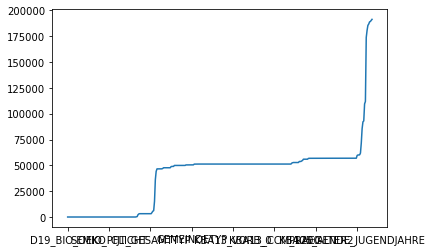

In [18]:
clean_customer_data.isnull().sum(axis=0).sort_values().plot()

### b. Removing data points with big number of missing features

In this step, we remove data points which have a lot of missing features

In [19]:
num_missing_features = (clean_customer_data.isnull().sum(axis = 1))

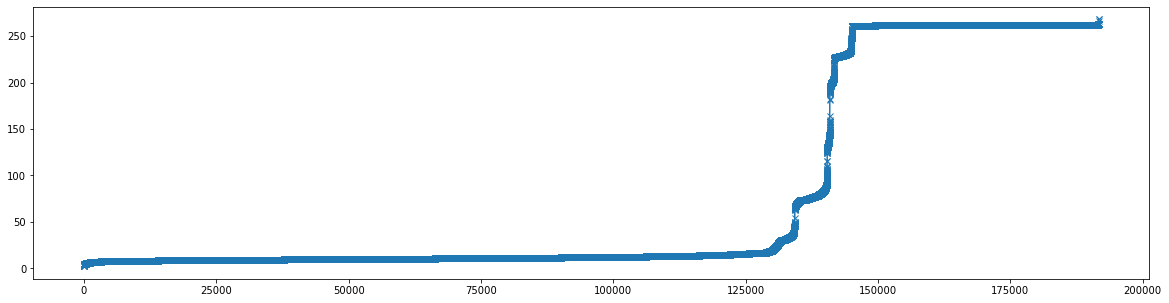

In [21]:
plt.figure(figsize=(20,5))
plt.plot(num_missing_features.sort_values().to_list(), "x-")
# plt.xticks(rotation = 90,fontsize=3) # Rotates X-Axis Ticks by 45-degrees
plt.show()

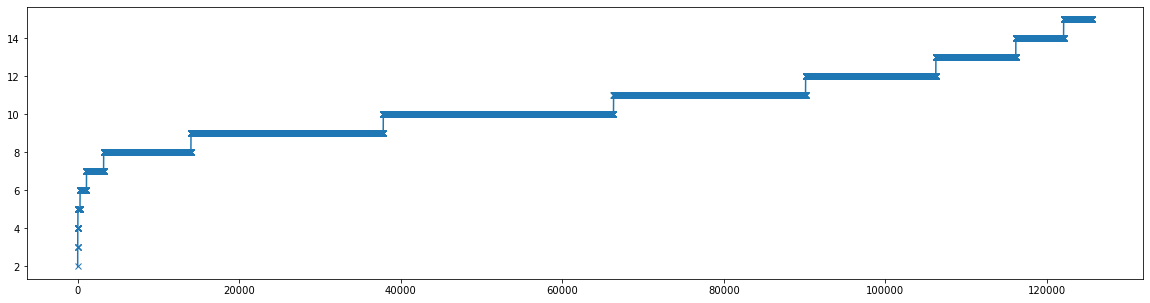

In [22]:
plt.figure(figsize=(20,5))
plt.plot(num_missing_features.sort_values()[num_missing_features<=15].to_list(), "x-")
# plt.xticks(rotation = 90,fontsize=3) # Rotates X-Axis Ticks by 45-degrees
plt.show()

In [23]:
num_missing_features[num_missing_features<=15].size/num_missing_features.size

0.6553440611107633

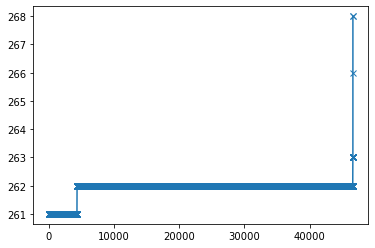

In [24]:
plt.plot(num_missing_features[num_missing_features>=260].sort_values().to_list(), "x-")

In [96]:
#num_missing_people[num_missing_people>=260].size/num_missing_people.size

0.24314904097009163

In [97]:
#260/369

0.7046070460704607

It turns out that most datapoint have missing features, about 1/4 data has over 260 or 70% percent of missing features.

Looking at the distribution of number of missing features, there is a turning point at around 65% of data, a threshold of 20 missing features, after which the number of missing features increases dramatically. That turning point is about 65% of data ~ 129434 data. Therefore, I pick these number of data and decide to discard data that has number of features more than that.

In [25]:
keep_index = num_missing_features[num_missing_features<=15].index

In [26]:
keep_index.size

125598

In [27]:
clean_customer_data = clean_customer_data.loc[keep_index, :]

Take a look at missing data again:

<AxesSubplot:>

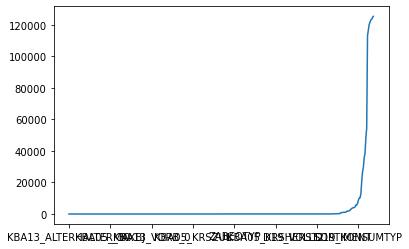

In [28]:
clean_customer_data.isnull().sum(axis=0).sort_values().plot()

### c. Removing features with big number of missing data
In this step, I remove features that most data point do not have

In [29]:
num_missing_features = clean_customer_data.isnull().sum(axis = 0)

302 features are present for all data points

In [30]:
num_missing_features[num_missing_features == 0].size

302

In [31]:
num_missing_features[num_missing_features > 0].size

67

Only 67 features are not found in each datapoint. Instead of discarding them, might make sense to keep some of them.

In [32]:
num_missing_features[num_missing_features > 0].divide(clean_customer_data.index.size).sort_values().to_dict()

{'LNR': 7.961910221500342e-06,
 'KBA05_AUTOQUOT': 7.961910221500342e-06,
 'KBA05_GBZ': 1.5923820443000684e-05,
 'KONSUMNAEHE': 3.9809551107501713e-05,
 'KOMBIALTER': 4.777146132900205e-05,
 'BALLRAUM': 0.00013535247376550582,
 'INNENSTADT': 0.00013535247376550582,
 'EWDICHTE': 0.00013535247376550582,
 'PLZ8_ANTG2': 0.0003184764088600137,
 'PLZ8_ANTG4': 0.0003184764088600137,
 'PLZ8_BAUMAX': 0.0003184764088600137,
 'PLZ8_GBZ': 0.0003184764088600137,
 'PLZ8_HHZ': 0.0003184764088600137,
 'PLZ8_ANTG3': 0.0003184764088600137,
 'PLZ8_ANTG1': 0.0003184764088600137,
 'CAMEO_DEU_2015': 0.0006528766381630281,
 'CAMEO_DEUG_2015': 0.0006528766381630281,
 'CAMEO_INTL_2015': 0.0006528766381630281,
 'UMFELD_ALT': 0.0008678482141435373,
 'UMFELD_JUNG': 0.0008678482141435373,
 'ALTERSKATEGORIE_GROB': 0.0011465150718960493,
 'STRUKTURTYP': 0.00163219159540757,
 'GEMEINDETYP': 0.00163219159540757,
 'RELAT_AB': 0.0017516202487300753,
 'ARBEIT': 0.0017516202487300753,
 'KBA05_HERSTTEMP': 0.0019825156451535

Keep features that less than 20% of data are missing

https://discuss.analyticsvidhya.com/t/what-should-be-the-allowed-percentage-of-missing-values/2456

In [33]:
keep_features = num_missing_features[num_missing_features.divide(clean_customer_data.index.size)<0.2].index

In [34]:
keep_features.size

355

In [35]:
clean_customer_data = clean_customer_data.loc[:,keep_features]

In [36]:
clean_customer_data.to_csv('clean_customer_data.csv')

In [131]:
clean_customer_data.head().transpose().iloc[:,:1].to_csv('features.csv')

In [37]:
clean_customer_data.head()

,LNR,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ARBEIT,BALLRAUM,...,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNLAGE,ZABEOTYP,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,9626.0,1.0,10.0,10.0,1.0,0.0,2.0,1.0,1.0,3.0,...,3.0,2.0,6.0,7.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,4.0
2,143872.0,1.0,6.0,0.0,1.0,0.0,1.0,1.0,3.0,7.0,...,13.0,11.0,6.0,2.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,2,4.0
4,143874.0,1.0,20.0,14.0,7.0,0.0,4.0,7.0,3.0,3.0,...,5.0,4.0,2.0,3.0,1,FOOD,MULTI_BUYER,0,1,3.0
5,143888.0,1.0,11.0,10.0,1.0,0.0,2.0,1.0,3.0,7.0,...,2.0,1.0,6.0,1.0,2,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,3.0
6,143904.0,1.0,10.0,10.0,1.0,0.0,2.0,1.0,2.0,6.0,...,4.0,2.0,6.0,7.0,1,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,4.0


-------

### d. Further cleaning

Before imputing missing data, let's examine our data and see if there are ones that needs further cleaning.

missing features explanation.

First, an important observation to make here: most features are ordinal, meaning variables have ordered categories. For example most features with name "KBA" has integer values ranging from -1 to 5 meaning "unknown", "very low", "low", "average", "high", "very high". As I will adopt PCA method for feature selection, it is fair to treat these features as numericcal in that we regard the feature value not as a represenation of an ordered category, but a continuous number. 

Convert all values to meaningful ordinal. Some features has alphabetical values, convert the values to numerical. Such features include: CAMEO_DEU_2015, OST_WST_KZ. 

For features meaning year or date time, use the year value. These features include: EINGEFUEGT_AM, EINGEZOGENAM_HH_JAHR, MIN_GEBAEUDEJAHR. 

Keep one in pairs of features of same meaning, but of different granuity. For example, CAMEO_DEU_2015 and CAMEO_DEUG_2015 have the same meaning but the latter is more granular. Such features include: (CAMEO_DEU_2015, CAMEO_DEUG_2015), (LP_LEBENSPHASE_FEIN, LP_LEBENSPHASE_GROB), (LP_FAMILIE_FEIN, LP_FAMILIE_GROB). 

Manually determine for binary categorical features. These features include: OST_WEST_KZ, 

Remove features with collinearity. 

First, I categorize each feature with one of the following labels: Numerical or Ordinal, Categorical and Date. Categorical 

In [450]:
?pd.read_csv

In [703]:
clean_customer_data = pd.read_csv("clean_customer_data.csv",index_col='Unnamed: 0')

/home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (12,13) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [704]:
print("Number of features in cleaned data: {}".format(clean_customer_data.columns.size))
print("Number of datapoints in cleaned data: {}".format(clean_customer_data.index.size))

Number of features in cleaned data: 355
Number of datapoints in cleaned data: 125598


In [705]:
clean_customer_data2 = clean_customer_data.copy()

#### 1. convert letter values to numeric

In [706]:
clean_customer_data.OST_WEST_KZ.dtype == 'O'

True

In [707]:
def convert_letter_values_to_numeric(df, columns):
    for column in columns:
        if not df[column].dtype == 'O':
            pass
        values = df[column].unique().tolist()
        values.sort()
        value2num = dict(zip(values,range(len(values))))
        df[column] = df[column].apply(lambda x:value2num[x])
    return df

In [708]:
clean_customer_data2 = convert_letter_values_to_numeric(clean_customer_data2, ['OST_WEST_KZ','D19_LETZTER_KAUF_BRANCHE'])

In [709]:
clean_customer_data2.OST_WEST_KZ.unique()

array([1, 0])

In [710]:
clean_customer_data2.D19_LETZTER_KAUF_BRANCHE.unique()

array([30, 24,  8, 10, 25, 26, 32,  1, 33, 15, 11, 22,  2, 31, 12,  4, 28,
       23,  0, 16, 27,  5,  3, 13, 14, 21,  9,  7, 18, 20,  6, 34, 29, 19,
       17])

#### 2. process date time to extract year

In [711]:
clean_customer_data.EINGEFUEGT_AM.unique()

array(['1992-02-12 00:00:00', '1992-02-10 00:00:00',
       '2004-10-14 00:00:00', ..., '2002-02-08 00:00:00',
       '2004-10-28 00:00:00', '2005-03-30 00:00:00'], dtype=object)

In [712]:
def process_datetime(df, columns):
    for column in columns:
        if isinstance(df[column][0], str):
            df[column] = df[column].apply(lambda x:int(x[:4]))
    return df

In [713]:
clean_customer_data2 = process_datetime(clean_customer_data2, ['EINGEFUEGT_AM'])

In [714]:
clean_customer_data2.EINGEFUEGT_AM.unique()

array([1992, 2004, 1997, 1995, 1996, 1994, 2003, 1993, 2005, 1998, 2000,
       1999, 2001, 2002])

#### 3. clean column CAMEO_DEUG

In [715]:
def process_CAMEO_DEUG(df):
    df.CAMEO_DEUG_2015 = df.CAMEO_DEUG_2015.apply(lambda x:0 if x=='X' else int(x) if not math.isnan(x) else x)

In [716]:
clean_customer_data.CAMEO_DEUG_2015.unique()

array(['1.0', '5.0', '7.0', '3.0', '9.0', '2.0', '4.0', '8.0', '6.0', nan,
       '6', '3', '8', '9', '2', '4', '1', '7', '5', 'X', 3.0, 4.0, 6.0,
       2.0, 9.0, 1.0, 5.0, 8.0, 7.0], dtype=object)

In [717]:
def get_int_or_nan(x):
    if isinstance(x, float) or isinstance(x, int):
        if math.isnan(x):
            return x
        else:
            return int(float(x))
    elif x[0].isdecimal():
        return int(float(x))
    elif x.isalpha():
        return np.nan
    else:
        return int(x)

In [718]:
clean_customer_data2.CAMEO_DEUG_2015 = clean_customer_data2.CAMEO_DEUG_2015.apply(get_int_or_nan)

In [719]:
clean_customer_data2.CAMEO_DEUG_2015.unique()

array([ 1.,  5.,  7.,  3.,  9.,  2.,  4.,  8.,  6., nan])

[]

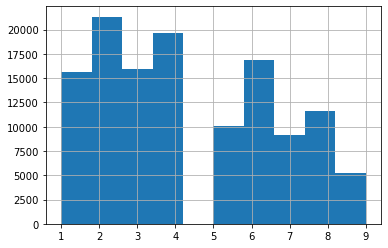

In [720]:
clean_customer_data2.CAMEO_DEUG_2015.hist().plot()

#### 4. Remove duplicate features 
- CAMEO_DEUG_2015, CAMEO_DEU_2015 --> drop CAMEO_DEU_2015
- ALTERSKATEGORIE_FEIN, ALTERSKATEGORIE_GROB -> drop ALTERSKATEGORIE_FEIN
- LP_LEBENSPHASE_FEIN, LP_LEBENSPHASE_GROB -> drop LP_LEBENSPHASE_FEIN
- LP_FAMILIE_FEIN, LP_FAMILIE_GROB -> drop LP_FAMILIE_FEIN

In [721]:
columns_to_remove = ['CAMEO_DEU_2015','ALTERSKATEGORIE_FEIN','LP_LEBENSPHASE_FEIN','LP_FAMILIE_FEIN']

In [722]:
def remove_columns(df, columns):
    drop_columns = []
    for c in columns:
        if c in df.columns:
            drop_columns.append(c)
    df = df.drop(columns=drop_columns)
    return df

In [723]:
clean_customer_data2 = remove_columns(clean_customer_data2, columns_to_remove)

In [724]:
'CAMEO_DEU_2015' in clean_customer_data2.columns

False

#### 5. Remove features that the number of mode has > 90% across all data

In [725]:
small_variation_features = \
clean_customer_data2.columns[clean_customer_data2.apply(lambda x: x.value_counts(normalize=True).to_list()[0])>0.9]

In [726]:
clean_customer_data2[small_variation_features].apply(lambda x :x.value_counts(normalize=True).to_list()[0])

ANZ_KINDER                    0.915373
D19_BANKEN_ANZ_12             0.917475
D19_BANKEN_LOKAL              0.969753
D19_BANKEN_OFFLINE_DATUM      0.945556
D19_BANKEN_ONLINE_QUOTE_12    0.951894
D19_DIGIT_SERV                0.942881
D19_GARTEN                    0.916687
D19_TELKO_ANZ_12              0.948701
D19_TELKO_ANZ_24              0.905779
D19_TELKO_ONLINE_DATUM        0.985079
D19_TELKO_ONLINE_QUOTE_12     0.998654
D19_TIERARTIKEL               0.944171
D19_VERSI_OFFLINE_DATUM       0.973220
D19_VERSI_ONLINE_DATUM        0.994635
D19_VERSI_ONLINE_QUOTE_12     0.998129
DSL_FLAG                      0.994347
KBA05_ANTG4                   0.903717
KBA13_KRSSEG_KLEIN            0.921711
NATIONALITAET_KZ              0.974082
OST_WEST_KZ                   0.921965
SOHO_KZ                       0.990239
UNGLEICHENN_FLAG              0.916822
ONLINE_PURCHASE               0.916145
dtype: float64

In [727]:
clean_customer_data2[small_variation_features[0]].value_counts(normalize=True)

0.0    0.915373
1.0    0.050335
2.0    0.025470
3.0    0.007094
4.0    0.001338
5.0    0.000334
6.0    0.000048
8.0    0.000008
Name: ANZ_KINDER, dtype: float64

In [728]:
clean_customer_data2 = remove_columns(clean_customer_data2, small_variation_features)

In [729]:
'D19_VERSI_ONLINE_QUOTE_12' in clean_customer_data2

False

#### 6. Remove unrelated features and categorical features that have too many categories

In [730]:
clean_customer_data2.VERS_TYP.value_counts()

2.0    62568
1.0    61833
Name: VERS_TYP, dtype: int64

In [731]:
'VERS_TYP' in clean_customer_data2.columns

True

In [732]:
drop_features = ['LNR','PRODUCT_GROUP','CUSTOMER_GROUP','CAMEO_INTL_2015']

In [733]:
clean_customer_data2 = remove_columns(clean_customer_data2, drop_features)

In [734]:
'CAMEO_INTL_2015' in clean_customer_data2.columns

False

#### 7. Remove features that have high correlation

In [735]:
THRESHOLD = .85

In [736]:
# def get_similar_columns(df, prefix):
#     target_columns = []
#     for c in clean_customer_data.columns:
#         if c.startswith(prefix):
#             target_columns.append(c)
#     return target_columns

In [737]:
#D19 = get_similar_columns(clean_customer_data, 'D19')

In [181]:
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_column', 100)

In [738]:
clean_customer_data2.columns.size

324

In [739]:
corr_df = clean_customer_data2.corr()# corr_D19 = clean_customer_data.loc[:,D19].corr().iloc[:10,:10]

In [740]:
corr_df.head()

,AKT_DAT_KL,ALTER_HH,ANZ_HAUSHALTE_AKTIV,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ARBEIT,BALLRAUM,CAMEO_DEUG_2015,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,D19_BILDUNG,D19_BIO_OEKO,D19_BUCH_CD,D19_DROGERIEARTIKEL,D19_ENERGIE,D19_FREIZEIT,D19_GESAMT_ANZ_12,D19_GESAMT_ANZ_24,D19_GESAMT_DATUM,D19_GESAMT_OFFLINE_DATUM,D19_GESAMT_ONLINE_DATUM,D19_GESAMT_ONLINE_QUOTE_12,D19_HANDWERK,D19_HAUS_DEKO,D19_KINDERARTIKEL,D19_KONSUMTYP,D19_KONSUMTYP_MAX,D19_KOSMETIK,D19_LEBENSMITTEL,D19_LETZTER_KAUF_BRANCHE,D19_LOTTO,D19_NAHRUNGSERGAENZUNG,D19_RATGEBER,D19_REISEN,D19_SAMMELARTIKEL,D19_SCHUHE,...,LP_STATUS_GROB,MIN_GEBAEUDEJAHR,MOBI_RASTER,MOBI_REGIO,ONLINE_AFFINITAET,ORTSGR_KLS9,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_GBZ,PLZ8_HHZ,PRAEGENDE_JUGENDJAHRE,REGIOTYP,RELAT_AB,RETOURTYP_BK_S,RT_KEIN_ANREIZ,RT_SCHNAEPPCHEN,RT_UEBERGROESSE,SEMIO_DOM,SEMIO_ERL,SEMIO_FAM,SEMIO_KAEM,SEMIO_KRIT,SEMIO_KULT,SEMIO_LUST,SEMIO_MAT,SEMIO_PFLICHT,SEMIO_RAT,SEMIO_REL,SEMIO_SOZ,SEMIO_TRADV,SEMIO_VERT,SHOPPER_TYP,STRUKTURTYP,UMFELD_ALT,UMFELD_JUNG,VERDICHTUNGSRAUM,VERS_TYP,VHA,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
AKT_DAT_KL,1.000000,0.035864,0.096270,-0.064851,0.094834,0.048757,-0.052593,0.066128,0.049748,-0.077049,0.172887,0.186474,-0.168543,-0.152669,-0.167463,-0.157193,0.020035,-0.020133,0.029403,0.027657,-0.026596,0.007566,0.002832,-0.000023,-0.035456,-0.004559,-0.026108,0.017353,-0.008578,0.011783,0.005991,0.033415,-0.042112,0.009226,-0.046585,0.037065,-0.052051,-0.004219,-0.004228,0.027054,0.037468,-0.063691,-0.002930,-0.031074,-0.084115,-0.023445,-0.016193,-0.059438,-0.049999,0.015798,...,-0.092742,0.003641,-0.076145,-0.094293,0.059996,0.054374,-0.071929,0.046912,0.070468,0.065522,0.075033,-0.041220,0.022919,0.175853,0.013044,0.034969,-0.050076,0.092059,-0.051367,0.058945,0.073572,-0.008115,0.004245,0.069783,0.071994,-0.005748,-0.088165,0.025768,0.083132,0.087995,0.040807,-0.017156,0.061605,-0.072407,0.008702,0.041586,0.011493,-0.028864,0.013406,0.024861,-0.061745,0.019001,0.051314,0.107801,0.131249,-0.035755,-0.026797,0.094145,0.060821,-0.124617
ALTER_HH,0.035864,1.000000,-0.081622,0.476729,-0.079666,-0.082391,0.057528,-0.082334,0.191966,-0.389910,0.285934,0.246674,-0.305701,-0.336413,-0.282358,-0.251204,0.151355,-0.192425,0.232547,0.132432,-0.152472,0.160092,0.109312,0.191795,0.105253,0.110114,0.119005,0.215779,0.075120,0.248407,0.313676,0.350346,-0.309257,-0.132956,-0.334918,0.274107,0.088391,0.190327,0.207160,-0.168629,-0.054697,0.108020,0.092567,-0.123251,0.068763,0.048199,0.147745,0.097279,0.051389,0.189070,...,0.094985,0.089542,0.117692,0.123808,0.381113,-0.095567,0.086838,-0.087523,-0.097979,-0.080664,-0.069557,0.056340,-0.019205,0.356067,0.017327,-0.086282,-0.155223,0.114639,-0.189401,0.319412,0.018072,-0.087796,0.077085,-0.027156,-0.135213,0.139117,-0.158998,0.024035,0.144069,0.139739,0.149444,0.040673,0.129642,0.051104,-0.017999,-0.082738,0.194391,0.008437,-0.017176,0.039483,0.080223,-0.073615,-0.286209,-0.165784,-0.055109,-0.477393,0.078916,-0.077582,-0.072274,-0.177876
ANZ_HAUSHALTE_AKTIV,0.096270,-0.081622,1.000000,-0.122937,0.990307,0.102210,-0.137737,0.288448,-0.021434,0.085328,0.020862,0.072068,-0.011065,-0.000640,-0.025667,-0.023599,-0.026879,0.036793,-0.036088,-0.014312,0.027438,-0.034779,-0.038965,-0.047613,-0.044281,-0.029530,-0.061586,-0.044839,-0.041581,-0.060230,-0.080106,-0.091857,0.090405,0.045713,0.085821,-0.067104,-0.055430,-0.063444,-0.059121,0.056594,0.050983,-0.034557,-0.027107,0.040227,-0.041630,-0.016127,-0.049489,-0.058871,-0.038400,-0.037068,...,-0.367719,-0.111540,-0.286064,-0.439602,-0.153753,0.150840,-0.247604,0.100683,0.222151,0.304598,0.305756,-0.234578,0.057936,-0.044514,0.062803,0.119043,0.059823,-0.011383,-0.052784,-0.121843,0.069790,0.05401

In [741]:
high_corr_feature_pairs = []
i = 0
for _, row in corr_df.iterrows():
    for j in range(i):
        if abs(corr_df.iloc[i,j]) > THRESHOLD:
            high_corr_feature_pairs.append((corr_df.columns[j], corr_df.columns[i]))
    i += 1

In [742]:
len(high_corr_feature_pairs)

32

In [743]:
def extract_columns(pairs_of_colums):
    res = []
    for c1, c2 in pairs_of_colums:
        if c2 not in res:
            res.append(c2)
    return res

In [744]:
high_corr_features_to_remove = extract_columns(high_corr_feature_pairs)

In [745]:
high_corr_features_to_remove

['ANZ_STATISTISCHE_HAUSHALTE',
 'D19_GESAMT_ANZ_24',
 'D19_VERSAND_ANZ_12',
 'D19_VERSAND_ANZ_24',
 'D19_VERSAND_OFFLINE_DATUM',
 'D19_VERSAND_ONLINE_DATUM',
 'D19_VERSAND_ONLINE_QUOTE_12',
 'FINANZ_VORSORGER',
 'KBA05_KRSHERST1',
 'KBA05_KRSHERST3',
 'KBA05_ZUL4',
 'KBA13_HALTER_55',
 'KBA13_HALTER_66',
 'KBA13_HERST_SONST',
 'KBA13_KMH_250',
 'KBA13_VW',
 'KOMBIALTER',
 'LP_LEBENSPHASE_GROB',
 'MIN_GEBAEUDEJAHR',
 'ORTSGR_KLS9',
 'PLZ8_ANTG1',
 'PLZ8_ANTG3',
 'PLZ8_ANTG4',
 'PLZ8_BAUMAX',
 'PLZ8_GBZ',
 'PLZ8_HHZ',
 'VK_ZG11',
 'ANREDE_KZ']

In [746]:
clean_customer_data2 = remove_columns(clean_customer_data2, high_corr_features_to_remove)

In [747]:
clean_customer_data2.columns.size

296

In [748]:
clean_customer_data2.head()

,AKT_DAT_KL,ALTER_HH,ANZ_HAUSHALTE_AKTIV,ANZ_PERSONEN,ARBEIT,BALLRAUM,CAMEO_DEUG_2015,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,D19_BILDUNG,D19_BIO_OEKO,D19_BUCH_CD,D19_DROGERIEARTIKEL,D19_ENERGIE,D19_FREIZEIT,D19_GESAMT_ANZ_12,D19_GESAMT_DATUM,D19_GESAMT_OFFLINE_DATUM,D19_GESAMT_ONLINE_DATUM,D19_GESAMT_ONLINE_QUOTE_12,D19_HANDWERK,D19_HAUS_DEKO,D19_KINDERARTIKEL,D19_KONSUMTYP,D19_KONSUMTYP_MAX,D19_KOSMETIK,D19_LEBENSMITTEL,D19_LETZTER_KAUF_BRANCHE,D19_LOTTO,D19_NAHRUNGSERGAENZUNG,D19_RATGEBER,D19_REISEN,D19_SAMMELARTIKEL,D19_SCHUHE,D19_SONSTIGE,D19_SOZIALES,...,KBA13_TOYOTA,KBA13_VORB_0,KBA13_VORB_1,KBA13_VORB_1_2,KBA13_VORB_2,KBA13_VORB_3,KKK,KONSUMNAEHE,KONSUMZELLE,LP_FAMILIE_GROB,LP_STATUS_GROB,MOBI_RASTER,MOBI_REGIO,ONLINE_AFFINITAET,PLZ8_ANTG2,PRAEGENDE_JUGENDJAHRE,REGIOTYP,RELAT_AB,RETOURTYP_BK_S,RT_KEIN_ANREIZ,RT_SCHNAEPPCHEN,RT_UEBERGROESSE,SEMIO_DOM,SEMIO_ERL,SEMIO_FAM,SEMIO_KAEM,SEMIO_KRIT,SEMIO_KULT,SEMIO_LUST,SEMIO_MAT,SEMIO_PFLICHT,SEMIO_RAT,SEMIO_REL,SEMIO_SOZ,SEMIO_TRADV,SEMIO_VERT,SHOPPER_TYP,STRUKTURTYP,UMFELD_ALT,UMFELD_JUNG,VERDICHTUNGSRAUM,VERS_TYP,VHA,VHN,VK_DHT4A,VK_DISTANZ,W_KEIT_KIND_HH,WOHNLAGE,ZABEOTYP,ALTERSKATEGORIE_GROB
0,1.0,10.0,1.0,2.0,1.0,3.0,1.0,5.0,4.0,1.0,1.0,5.0,5.0,5.0,5.0,0,10,0,0,10,0,0,0,0,0,6,0,0,0,0,9,9,10,0.0,0,6,0,3.0,2.0,0,6,30,0.0,0,0,0,6,0,6,1.0,...,2.0,4.0,3.0,3.0,3.0,1.0,1.0,5.0,0.0,2.0,5.0,3.0,4.0,3.0,3.0,4.0,1.0,1.0,5.0,1.0,5.0,3.0,1,3,5,1,3,4,7,6,2,1,2,6,1,6,3.0,3.0,4.0,4.0,8.0,1.0,0.0,3.0,5.0,3.0,6.0,7.0,3,4.0
2,1.0,6.0,1.0,1.0,3.0,7.0,5.0,2.0,5.0,2.0,2.0,5.0,5.0,5.0,5.0,0,10,0,0,10,0,0,0,6,0,0,0,0,0,0,10,10,10,0.0,0,0,0,3.0,2.0,0,0,30,7.0,0,0,6,6,0,6,1.0,...,3.0,4.0,2.0,2.0,3.0,4.0,3.0,1.0,1.0,1.0,5.0,1.0,3.0,1.0,3.0,4.0,7.0,3.0,5.0,1.0,5.0,1.0,5,7,2,6,7,1,7,3,4,2,1,2,1,3,1.0,3.0,1.0,5.0,0.0,2.0,0.0,4.0,10.0,13.0,6.0,2.0,3,4.0
4,1.0,20.0,7.0,4.0,3.0,3.0,7.0,6.0,4.0,3.0,3.0,3.0,4.0,3.0,3.0,2,3,5,0,7,0,0,6,0,0,2,4,0,6,3,1,8,1,10.0,0,6,0,1.0,4.0,0,5,24,0.0,0,6,0,6,3,6,1.0,...,3.0,3.0,3.0,3.0,3.0,0.0,4.0,1.0,1.0,5.0,1.0,1.0,3.0,5.0,4.0,8.0,7.0,1.0,5.0,4.0,3.0,5.0,5,4,5,2,3,5,6,6,5,5,4,4,4,5,1.0,3.0,2.0,4.0,1.0,2.0,0.0,4.0,3.0,5.0,2.0,3.0,1,3.0
5,1.0,11.0,1.0,2.0,3.0,7.0,5.0,4.0,3.0,1.0,1.0,5.0,5.0,5.0,5.0,0,10,0,0,10,0,0,6,0,0,5,0,0,0,0,6,6,10,0.0,6,0,0,2.0,2.0,0,0,8,7.0,0,0,0,0,0,6,1.0,...,4.0,4.0,3.0,3.0,2.0,1.0,2.0,2.0,0.0,2.0,3.0,2.0,3.0,3.0,3.0,4.0,3.0,5.0,3.0,1.0,5.0,2.0,5,4,4,3,5,6,6,1,3,2,4,6,4,7,1.0,3.0,2.0,5.0,24.0,2.0,5.0,4.0,1.0,2.0,6.0,1.0,2,3.0
6,1.0,10.0,1.0,2.0,2.0,6.0,3.0,2.0,5.0,1.0,1.0,5.0,5.0,5.0,5.0,0,10,0,0,10,0,6,6,7,0,0,3,0,0,2,5,5,5,7.0,6,6,0,2.0,2.0,0,6,10,7.0,3,0,0,6,0,3,1.0,...,3.0,3.0,3.0,3.0,4.0,3.0,2.0,4.0,0.0,2.0,5.0,2.0,4.0,4.0,2.0,4.0,3.0,2.0,5.0,3.0,5.0,3.0,1,3,2,2,3,4,5,1,2,3,5,4,4,6,0.0,1.0,4.0,5.0,0.0,1.0,0.0,4.0,3.0,4.0,6.0,7.0,1,4.0


#### 8. Impute missing values

In [749]:
numerical_columns = ['ALTER_HH','ANZ_HAUSHALTE_AKTIV', 'ANZ_PERSONEN', 'EINGEFUEGT_AM','EINGEZOGENAM_HH_JAHR','KBA13_ANZAHL_PKW','VERDICHTUNGSRAUM']

In [750]:
clean_customer_data2['ANZ_HAUSHALTE_AKTIV'].value_counts(normalize=True)[:10]

1.0     0.537333
2.0     0.166343
3.0     0.058213
4.0     0.033626
5.0     0.026269
6.0     0.024277
7.0     0.022276
8.0     0.019900
10.0    0.013808
Name: ANZ_HAUSHALTE_AKTIV, dtype: float64

ALTER_HH
ANZ_HAUSHALTE_AKTIV
ANZ_PERSONEN
EINGEFUEGT_AM
EINGEZOGENAM_HH_JAHR
KBA13_ANZAHL_PKW
VERDICHTUNGSRAUM


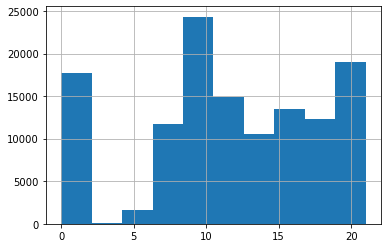

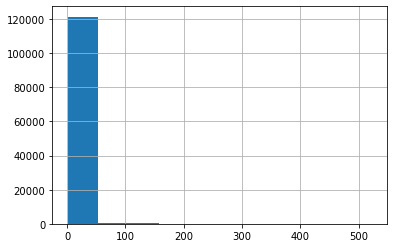

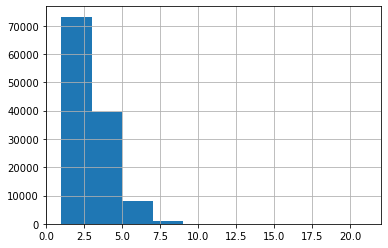

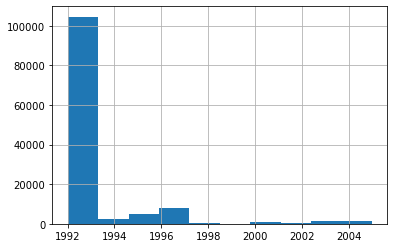

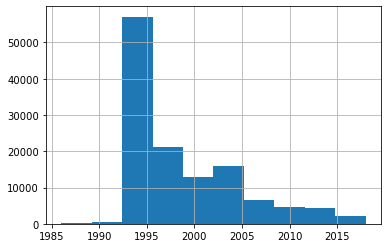

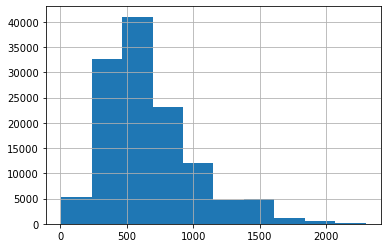

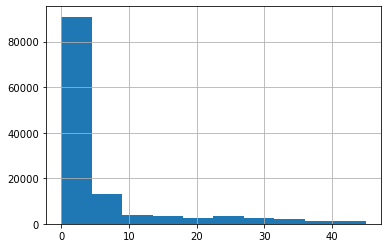

In [751]:
for i in range(len(numerical_columns)):
    plt.figure()
    clean_customer_data2[numerical_columns[i]].hist().plot(label=numerical_columns[i])
    print(numerical_columns[i])

In [752]:
oc_values = list(set(clean_customer_data2.columns) - set(numerical_columns))

In [753]:
columns_to_one_hot = ['CJT_GESAMTTYP','VERS_TYP','D19_LETZTER_KAUF_BRANCHE','GEBAEUDETYP', 'GEBAEUDETYP_RASTER',\
   'GEMEINDETYP', 'GFK_URLAUBERTYP', 'HEALTH_TYP', 'LP_FAMILIE_GROB', 'REGIOTYP', 'RETOURTYP_BK_S', 'SHOPPER_TYP', 'STRUKTURTYP','ZABEOTYP'\
                     ]

In [754]:
# for categorical or ordinal values, impute with mode
def impute_with_mode(df, columns):
    df = df.copy
    for column in columns:
        df[column] = df[column].fillna(df[column].mode())
    return df

In [755]:
# for numerical values, impute with median
def impute_with_median(df, columns):
    for column in columns:
        df[column] = df[column].fillna(df[column].median())
    return df

In [756]:
clean_customer_data2 = impute_with_median(clean_customer_data2, numerical_columns)    

In [765]:
clean_customer_data2 = impute_with_median(clean_customer_data2, clean_customer_data2.columns)    

In [595]:
#clean_customer_data2 = impute_with_median(clean_customer_data2, list(set(clean_customer_data2.columns) - set(numerical_columns)))   

In [758]:
numerical_columns

['ALTER_HH',
 'ANZ_HAUSHALTE_AKTIV',
 'ANZ_PERSONEN',
 'EINGEFUEGT_AM',
 'EINGEZOGENAM_HH_JAHR',
 'KBA13_ANZAHL_PKW',
 'VERDICHTUNGSRAUM']

- CAMEO_DEUG_2015 and CAMEO_DEU_2015 are similar features but the former is grainer than the later. Discard the later one and transform former to one-hot in later stage.
- EIGEFEUGT_AM is a timedate feature, just take the year 
- MIN_GEBAEUDER_JAHR, EIGEZOGENAM_HH_JAHR is in years A.D. Need to normalize
- OST_WST_KZ has two values: W, O should convert to 0,1
- ALTER_HH, ALTERSKATEGORIE_FEIN, ANZ_HAUSHALTE_AKTIV, ANZ_KINDER, ANZ_PERSONEN, ANZ_STATISTISCHE_HAUSHALTE, PREGENDE_JUGENDJAHR, VERDICHTUNGSRAUM
- LP_FAMILIE_GROB : different values have same meaning, same feature as LP_FAMILIE_FEIN
- remove duplicate f

#### 9. Convert continuous feature to log scale:

In [803]:
columns_to_log_scale = ['VERDICHTUNGSRAUM','ANZ_HAUSHALTE_AKTIV','KBA13_ANZAHL_PKW']

In [760]:
def convert_to_log(df, columns):
    for column in columns:
        df[column] = df[column].apply(lambda x:np.log(1+x))
    return df

In [761]:
clean_customer_data2 = convert_to_log(clean_customer_data2, columns_to_log_scale)

[]

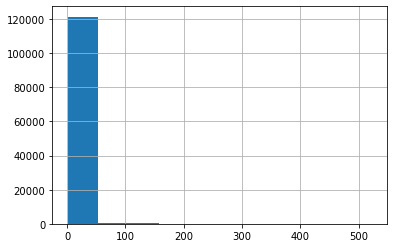

In [586]:
clean_customer_data[numerical_columns[1]].hist().plot()

[]

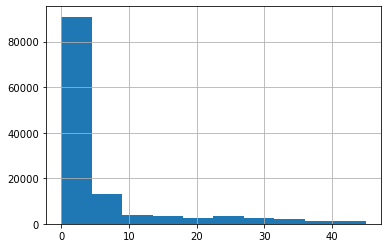

In [627]:
clean_customer_data[numerical_columns[-1]].hist().plot()

ALTER_HH
ANZ_HAUSHALTE_AKTIV
ANZ_PERSONEN
EINGEFUEGT_AM
EINGEZOGENAM_HH_JAHR
KBA13_ANZAHL_PKW
VERDICHTUNGSRAUM


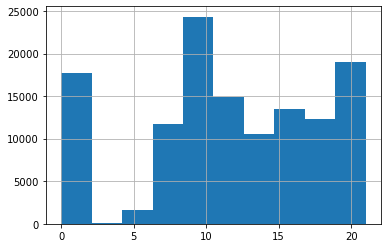

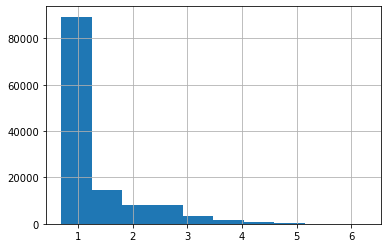

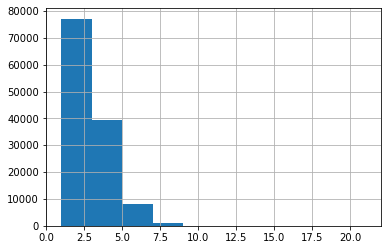

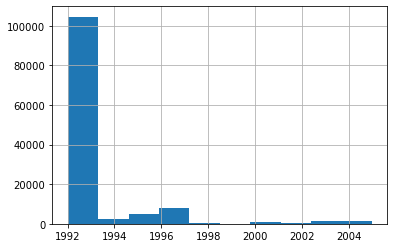

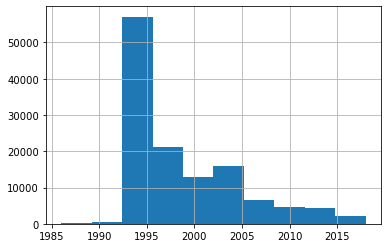

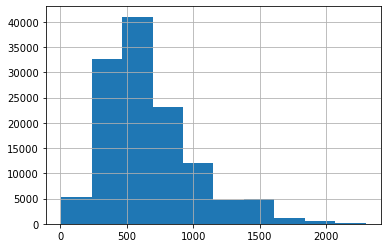

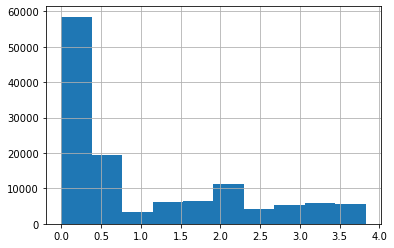

In [762]:
for i in range(len(numerical_columns)):
    plt.figure()
    clean_customer_data2[numerical_columns[i]].hist().plot(label=numerical_columns[i])
    print(numerical_columns[i])

In [766]:
clean_customer_data2[oc_values].apply(lambda x:x.unique()).to_dict()

{'KBA05_MOD2': array([4., 3., 5., 2., 1.]),
 'KBA13_KW_120': array([3., 1., 5., 4., 0., 2.]),
 'GEBAEUDETYP_RASTER': array([4., 3., 2., 5., 1.]),
 'KBA13_CCM_3001': array([3., 1., 4., 5., 2.]),
 'KONSUMNAEHE': array([5., 1., 2., 4., 3., 6., 7.]),
 'KBA13_VORB_3': array([1., 4., 0., 3., 2., 5.]),
 'VERS_TYP': array([1., 2.]),
 'KBA05_ZUL2': array([4., 3., 5., 2., 1.]),
 'D19_BIO_OEKO': array([0, 2, 3, 6, 7, 5, 4, 1]),
 'KBA13_ANTG4': array([0., 1., 2.]),
 'KBA05_ALTER2': array([2., 4., 3., 1., 5.]),
 'KBA13_OPEL': array([3., 1., 4., 2., 5.]),
 'KBA05_KRSKLEIN': array([2., 1., 3.]),
 'D19_KINDERARTIKEL': array([0, 2, 6, 3, 7, 5, 1, 4]),
 'KBA13_KW_60': array([3., 4., 0., 1., 2., 5.]),
 'KBA13_SEG_SPORTWAGEN': array([4., 3., 5., 1., 0., 2.]),
 'KBA13_CCM_3000': array([3., 5., 4., 2., 0., 1.]),
 'KBA05_SEG1': array([1., 0., 2., 3.]),
 'RT_SCHNAEPPCHEN': array([5., 3., 2., 4., 1.]),
 'KBA13_FAB_SONSTIGE': array([3., 2., 5., 4., 1.]),
 'CJT_GESAMTTYP': array([5., 2., 6., 4., 1., 3.]),
 'KBA1

In [634]:
#clean_customer_data2 = pd.read_csv('clean_and_imputed_data_before_one_hot.csv')

#### 10. Remove outliers for numerical features

In [767]:
outlier_indices = set()

[]

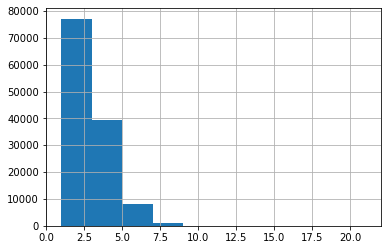

In [768]:
clean_customer_data2.ANZ_PERSONEN.hist().plot()

In [769]:
clean_customer_data2.ANZ_PERSONEN[clean_customer_data2.ANZ_PERSONEN>7]

417        8.0
860        8.0
1775       8.0
3273      12.0
4039       8.0
          ... 
189859     8.0
189977     8.0
190050    12.0
190168     8.0
190208     8.0
Name: ANZ_PERSONEN, Length: 255, dtype: float64

In [770]:
outlier_indices.update(clean_customer_data2.ANZ_PERSONEN[clean_customer_data2.ANZ_PERSONEN>7].index)

[]

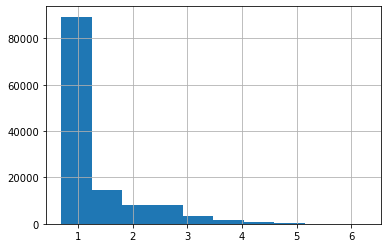

In [771]:
clean_customer_data2.ANZ_HAUSHALTE_AKTIV.hist().plot()

In [772]:
clean_customer_data2.ANZ_HAUSHALTE_AKTIV[clean_customer_data2.ANZ_HAUSHALTE_AKTIV>4]

8         4.317488
45        4.025352
96        4.691348
664       5.723585
1056      4.060443
            ...   
190897    5.583496
191000    4.682131
191100    4.174387
191231    5.583496
191629    4.584967
Name: ANZ_HAUSHALTE_AKTIV, Length: 1130, dtype: float64

In [773]:
outlier_indices.update(clean_customer_data2.ANZ_HAUSHALTE_AKTIV[clean_customer_data2.ANZ_HAUSHALTE_AKTIV>4].index)

[]

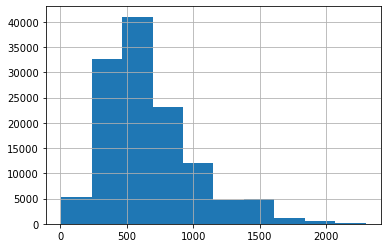

In [774]:
clean_customer_data2.KBA13_ANZAHL_PKW.hist().plot()

In [775]:
clean_customer_data2.KBA13_ANZAHL_PKW[clean_customer_data2.KBA13_ANZAHL_PKW>=2000]

1313      2100.0
1338      2300.0
1495      2000.0
2338      2300.0
2508      2000.0
           ...  
187035    2100.0
189135    2000.0
189355    2000.0
190120    2200.0
190851    2000.0
Name: KBA13_ANZAHL_PKW, Length: 439, dtype: float64

In [776]:
outlier_indices.update(clean_customer_data2.KBA13_ANZAHL_PKW[clean_customer_data2.KBA13_ANZAHL_PKW>=2000].index)

In [777]:
len(list(outlier_indices))

1818

In [778]:
clean_customer_data2 = clean_customer_data2.drop(index=list(outlier_indices))

In [779]:
clean_customer_data2.columns.size

296

In [780]:
numerical_columns

['ALTER_HH',
 'ANZ_HAUSHALTE_AKTIV',
 'ANZ_PERSONEN',
 'EINGEFUEGT_AM',
 'EINGEZOGENAM_HH_JAHR',
 'KBA13_ANZAHL_PKW',
 'VERDICHTUNGSRAUM']

In [782]:
clean_customer_data2['ANZ_PERSONEN'].isnull().sum()


0

In [783]:
clean_customer_data2.to_csv('clean_and_imputed_data_before_one_hot.csv')

#### 11. One-hot encoding

In [784]:
for c in columns_to_one_hot:
    if c not in clean_customer_data2.columns:
        print(c)

In [785]:
def convert_to_one_hot(df, columns):
    for column in columns:
        one_hot = pd.get_dummies(df[column])
        one_hot.columns = list(map(lambda x:column+str(int(x)), one_hot.columns))
        df = df.drop(columns=column)
        df = df.join(one_hot)
    return df

In [786]:
clean_customer_data3 = convert_to_one_hot(clean_customer_data2, columns_to_one_hot)

In [787]:
clean_customer_data3.index.size

123780

In [788]:
clean_customer_data3.columns.size

389

In [867]:
clean_customer_data3.to_csv('final_customer_data.csv')

In [805]:
clean_customer_data3['KBA13_ANZAHL_PKW'] = np.log(1+clean_customer_data3['KBA13_ANZAHL_PKW'])

[]

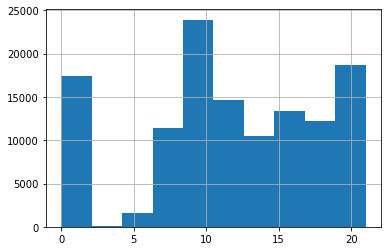

In [812]:
clean_customer_data3['ALTER_HH'].hist().plot()

### PCA

In [810]:
numerical_columns

['ALTER_HH',
 'ANZ_HAUSHALTE_AKTIV',
 'ANZ_PERSONEN',
 'EINGEFUEGT_AM',
 'EINGEZOGENAM_HH_JAHR',
 'KBA13_ANZAHL_PKW',
 'VERDICHTUNGSRAUM']

In [790]:
from sklearn.decomposition import PCA

In [826]:
pca = PCA(n_components=100)

In [869]:
from sklearn.preprocessing import MinMaxScaler

scaler=MinMaxScaler()
# store them in this dataframe
customer_data_scaled=pd.DataFrame(scaler.fit_transform(clean_customer_data3.astype(float)))

# get same features and State-County indices
customer_data_scaled.columns=clean_customer_data3.columns
customer_data_scaled.index=clean_customer_data3.index

In [878]:
customer_data_scaled.head()

,AKT_DAT_KL,ALTER_HH,ANZ_HAUSHALTE_AKTIV,ANZ_PERSONEN,ARBEIT,BALLRAUM,CAMEO_DEUG_2015,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,D19_BILDUNG,D19_BIO_OEKO,D19_BUCH_CD,D19_DROGERIEARTIKEL,D19_ENERGIE,D19_FREIZEIT,D19_GESAMT_ANZ_12,D19_GESAMT_DATUM,D19_GESAMT_OFFLINE_DATUM,D19_GESAMT_ONLINE_DATUM,D19_GESAMT_ONLINE_QUOTE_12,D19_HANDWERK,D19_HAUS_DEKO,D19_KINDERARTIKEL,D19_KONSUMTYP,D19_KONSUMTYP_MAX,D19_KOSMETIK,D19_LEBENSMITTEL,D19_LOTTO,D19_NAHRUNGSERGAENZUNG,D19_RATGEBER,D19_REISEN,D19_SAMMELARTIKEL,D19_SCHUHE,D19_SONSTIGE,D19_SOZIALES,D19_TECHNIK,D19_TELKO_DATUM,...,GEMEINDETYP22,GEMEINDETYP30,GEMEINDETYP40,GEMEINDETYP50,GFK_URLAUBERTYP1,GFK_URLAUBERTYP2,GFK_URLAUBERTYP3,GFK_URLAUBERTYP4,GFK_URLAUBERTYP5,GFK_URLAUBERTYP6,GFK_URLAUBERTYP7,GFK_URLAUBERTYP8,GFK_URLAUBERTYP9,GFK_URLAUBERTYP10,GFK_URLAUBERTYP11,GFK_URLAUBERTYP12,HEALTH_TYP1,HEALTH_TYP2,HEALTH_TYP3,LP_FAMILIE_GROB0,LP_FAMILIE_GROB1,LP_FAMILIE_GROB2,LP_FAMILIE_GROB3,LP_FAMILIE_GROB4,LP_FAMILIE_GROB5,REGIOTYP1,REGIOTYP2,REGIOTYP3,REGIOTYP4,REGIOTYP5,REGIOTYP6,REGIOTYP7,RETOURTYP_BK_S1,RETOURTYP_BK_S2,RETOURTYP_BK_S3,RETOURTYP_BK_S4,RETOURTYP_BK_S5,SHOPPER_TYP0,SHOPPER_TYP1,SHOPPER_TYP2,SHOPPER_TYP3,STRUKTURTYP1,STRUKTURTYP2,STRUKTURTYP3,ZABEOTYP1,ZABEOTYP2,ZABEOTYP3,ZABEOTYP4,ZABEOTYP5,ZABEOTYP6
0,0.0,0.476190,0.00000,0.166667,0.00,0.333333,0.00,0.75,0.00,0.00,1.0,1.00,1.0,1.0,0.000000,1.000000,0.000000,0.0,1.000000,0.0,0.000000,0.000000,0.000000,0.0,0.857143,0.000000,0.0,0.000000,0.000000,0.888889,0.888889,1.000000,0.0,0.000000,0.857143,0.0,0.4,0.142857,0.0,0.857143,0.0,0.000000,0.000000,0.000000,0.857143,0.000000,0.857143,0.2,0.857143,1.000000,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
2,0.0,0.285714,0.00000,0.000000,0.50,1.000000,0.50,1.00,0.25,0.25,1.0,1.00,1.0,1.0,0.000000,1.000000,0.000000,0.0,1.000000,0.0,0.000000,0.000000,0.857143,0.0,0.000000,0.000000,0.0,0.000000,0.000000,1.000000,1.000000,1.000000,0.0,0.000000,0.000000,0.0,0.4,0.142857,0.0,0.000000,1.0,0.000000,0.000000,0.857143,0.857143,0.000000,0.857143,0.2,0.000000,1.000000,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0.0,0.952381,0.42062,0.500000,0.50,0.333333,0.75,0.75,0.50,0.50,0.5,0.75,0.5,0.5,0.333333,0.222222,0.714286,0.0,0.666667,0.0,0.000000,0.857143,0.000000,0.0,0.285714,0.571429,0.0,0.857143,0.500000,0.000000,0.777778,0.000000,1.0,0.000000,0.857143,0.0,0.0,0.428571,0.0,0.714286,0.0,0.000000,0.857143,0.000000,0.857143,0.428571,0.857143,0.2,0.857143,0.666667,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.523810,0.00000,0.166667,0.50,1.000000,0.50,0.50,0.00,0.00,1.0,1.00,1.0,1.0,0.000000,1.000000,0.000000,0.0,1.000000,0.0,0.000000,0.857143,0.000000,0.0,0.714286,0.000000,0.0,0.000000,0.000000,0.555556,0.555556,1.000000,0.0,0.857143,0.000000,0.0,0.2,0.142857,0.0,0.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.857143,0.2,0.857143,1.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
6,0.0,0.476190,0.00000,0.166667,0.25,0.833333,0.25,1.00,0.00,0.00,1.0,1.00,1.0,1.0,0.000000,1.000000,0.000000,0.0,1.000000,0.0,0.857143,0.857143,1.000000,0.0,0.000000,0.428571,0.0,0.000000,0.333333,0.444444,0.444444,0.444444,0.7,0.857143,0.857143,0.0,0.2,0.142857,0.0,0.857143,1.0,0.428571,0.00000

In [870]:
pca_result = pca.fit(clean_customer_data3)

In [871]:
explained_variance = []
curr = 0
for i in pca_result.explained_variance_ratio_:
    curr += i
    explained_variance.append(curr)

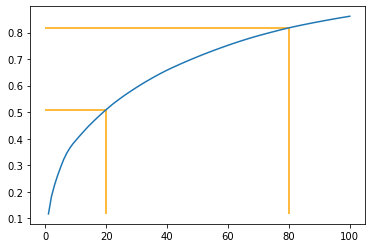

In [872]:
plt.plot(range(1,101),explained_variance)
plt.vlines(20,explained_variance[19],explained_variance[0],color='orange')
plt.hlines(explained_variance[19],0,20,color='orange')
plt.vlines(80,explained_variance[79],explained_variance[0],color='orange')
plt.hlines(explained_variance[79],0,80,color='orange')

In [873]:
print(pca_result.explained_variance_ratio_)

[0.11610244 0.06652096 0.04268401 0.03562186 0.03147189 0.029253
 0.02345939 0.01909445 0.01593781 0.01352122 0.01328991 0.01289365
 0.01266006 0.01251399 0.01149596 0.01125725 0.01091782 0.01066315
 0.01051744 0.01000397 0.00977915 0.00965916 0.00889292 0.00852458
 0.00846137 0.00819847 0.0078113  0.00770163 0.00746626 0.00742146
 0.00719316 0.00713209 0.00692073 0.00659679 0.00658054 0.00637733
 0.00622883 0.00621063 0.00584171 0.00570393 0.00553479 0.00537339
 0.00519207 0.00514978 0.00506505 0.00495987 0.00491479 0.00485442
 0.0047778  0.00471642 0.00466951 0.00452673 0.00445877 0.00444387
 0.00436935 0.00427351 0.00420417 0.00413083 0.00410575 0.0040292
 0.00394841 0.00394174 0.00378625 0.00369619 0.00367687 0.0036127
 0.00352004 0.00343262 0.00329375 0.00327181 0.00321148 0.00307318
 0.00303124 0.00301625 0.00300478 0.00293495 0.00289241 0.00285184
 0.00277759 0.0026885  0.00268074 0.00249571 0.00246506 0.00239857
 0.00237048 0.00230771 0.00230103 0.0022243  0.0022013  0.00215822

In [874]:
pca_result.components_.shape

(100, 389)

In [817]:
# feature_value_map = pd.Series(pca_result.components_[0],index=clean_customer_data3.columns)

In [875]:
top_20_features = []

In [876]:
# feature_to_coef = pd.DataFrame(feature_value_map.sort_values()[::-1][:10], columns=['feature','weight'])
for i in range(20):
    feature_value_map = pd.Series(pca_result.components_[i],index=clean_customer_data3.columns)
    features = feature_value_map.sort_values(key=abs)[::-1][:20].index
    values =  feature_value_map.sort_values(key=abs)[::-1][:20].values
    top_20_features.append((features, values))

In [833]:
import seaborn as sns


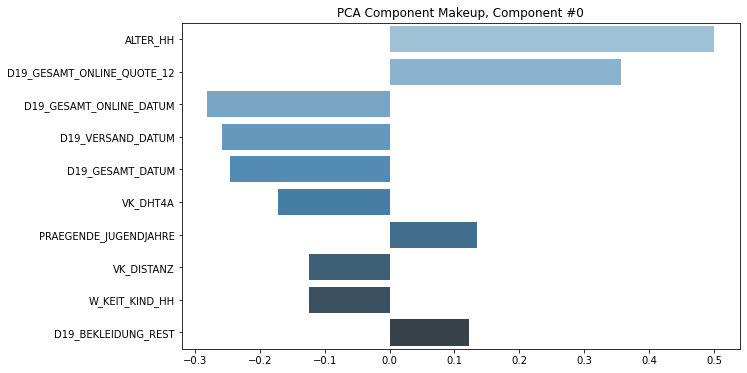

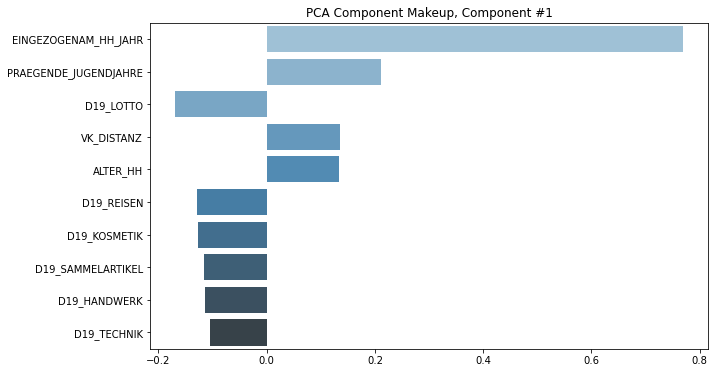

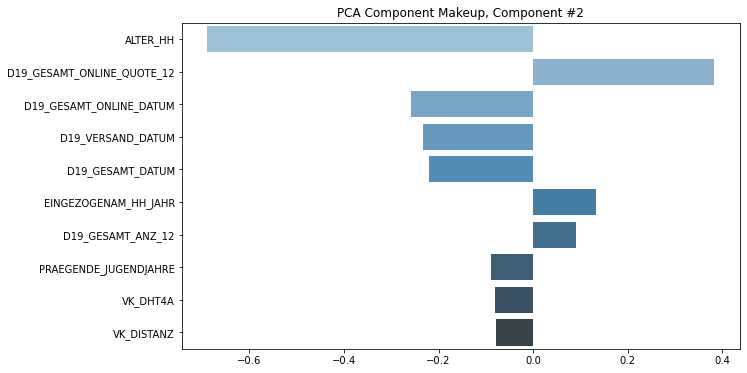

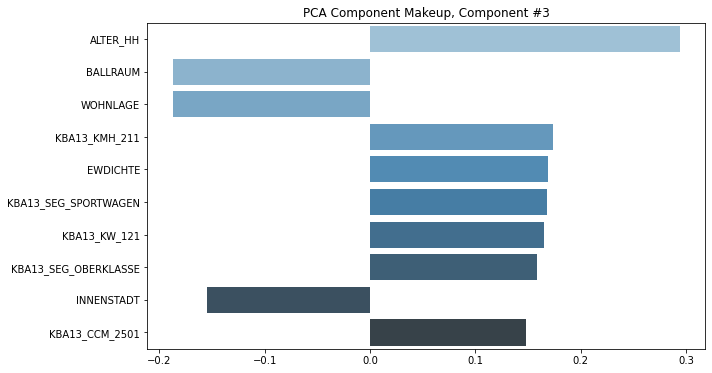

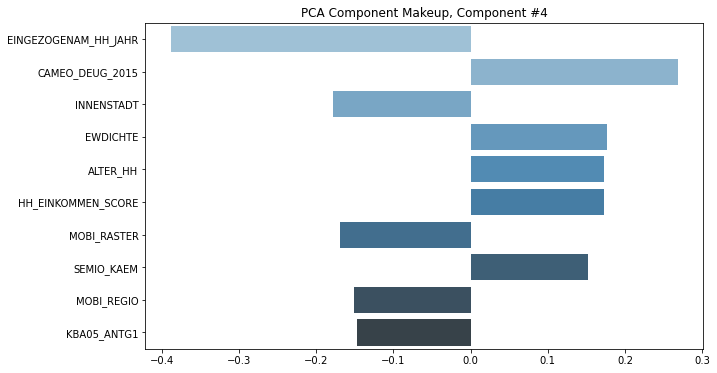

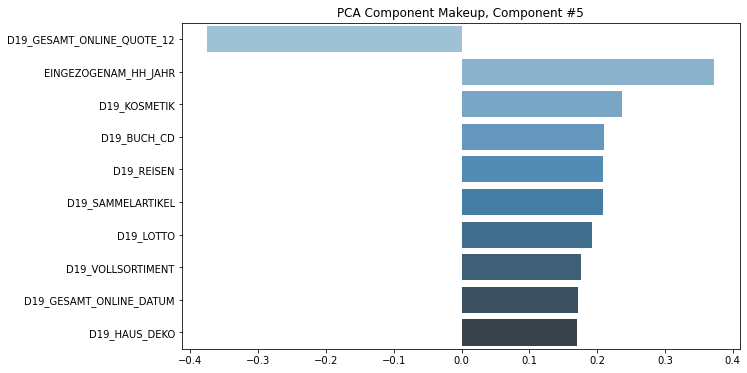

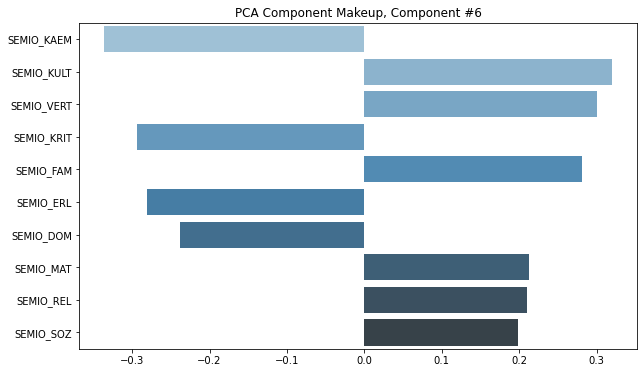

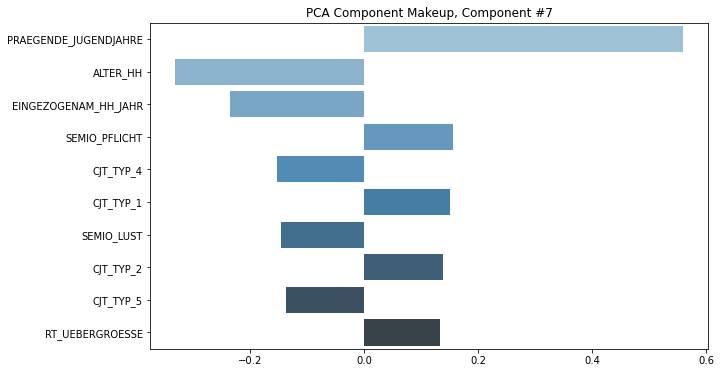

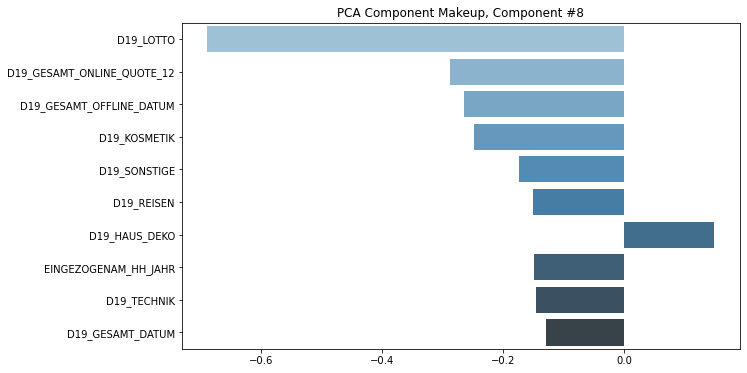

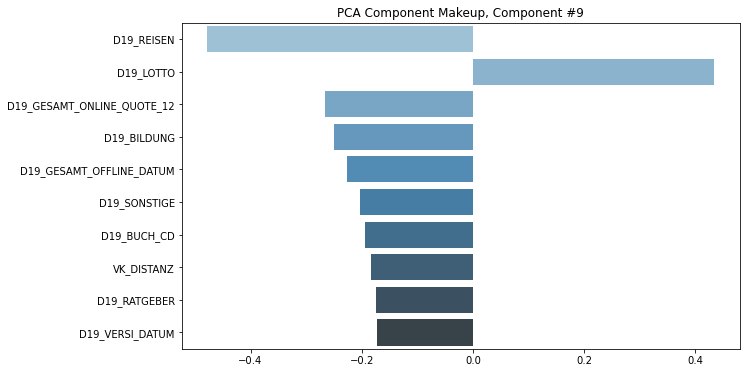

In [877]:
for i in range(10):
    ax=plt.subplots(figsize=(10,6))
    ax=sns.barplot(x=top_10_features[i][1], 
                   y=top_10_features[i][0], 
                   palette="Blues_d")
    ax.set_title("PCA Component Makeup, Component #" + str(i))
    plt.show()

In [ ]:
# Be sure to add in a lot more cells (both markdown and code) to document your
# approach and findings!

In [879]:
transformed_data = pd.DataFrame(columns=range(20),index=clean_customer_data3.index)

In [881]:
for i in range(20):
    transformed_data[i] = 

(389,)

The on-hot data was not used

## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [ ]:
mailout_train = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')

## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter.

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [ ]:
mailout_test = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TEST.csv', sep=';')